# Part 1 - Model Selection

A while back, I looked at the distribution of hit outcomes based on launch angle and exit velocity. Lately, I've been thinking about employing a model to predicting those outcomes. First, I'll start by reproducing the launch angle/exit velocity plot, then test out some models. Start by load packages and sift through data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pybaseball import statcast
import numpy as np
np.random.seed(42) # for reproducibility 
pd.options.display.max_columns = 999
import os
import sys
# Locally defined things
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/python/")
from helper_functions import scrub_stringers
from feature_builder import *


year = '2018'
saveDir = '../run/part1/'
refresh_data = False
if refresh_data:
    data = statcast(start_dt=year+'-03-29', end_dt=year+'-10-28')
    data.to_feather("../data/2018_data_raw.feather")    
else:
    data = pd.read_feather("../data/2018_data_raw.feather")


Scrub out streamers, then filter only to the outcomes to look at (balls in play)

In [2]:
scrub_data = scrub_stringers(data)
scrub_data["events"].value_counts()

field_out                       66275
strikeout                       41676
single                          25550
walk                            14989
double                           8304
home_run                         5653
grounded_into_double_play        3323
force_out                        3312
hit_by_pitch                     1946
field_error                      1439
sac_fly                          1232
triple                            853
double_play                       439
fielders_choice_out               280
caught_stealing_2b                214
sac_bunt                          176
strikeout_double_play             166
fielders_choice                    81
other_out                          55
pickoff_caught_stealing_2b         43
catcher_interf                     42
pickoff_1b                         40
pickoff_2b                         16
caught_stealing_3b                 16
caught_stealing_home               13
sac_fly_double_play                10
pickoff_caug

In [3]:
targets = ["field_out", "single", "double",  "triple", "home_run"]
target_df = scrub_data[scrub_data['events'].isin(targets)]


and generate plot...

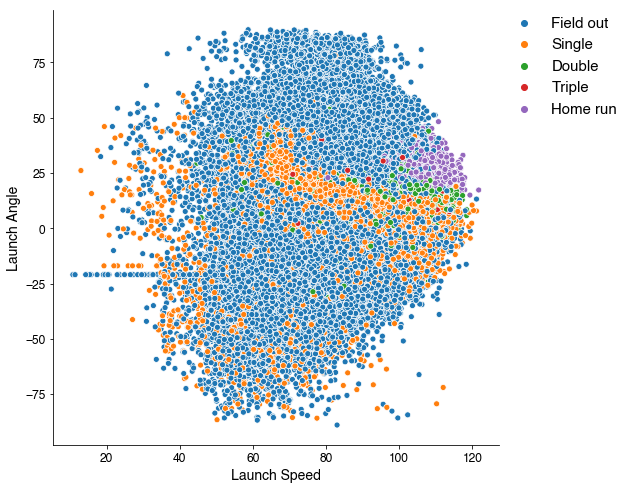

In [4]:
fig = plt.figure(figsize=(8,8))
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='events', 
           data=target_df,hue_order=targets, markers={"s": 10, "alpha" : 0.5},ax=plt.gca())
sns.despine()
plt.ylabel("Launch Angle", fontsize=14)
plt.xlabel("Launch Speed", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.savefig(saveDir+"2018_results", bbox_inches='tight')

## Start work on modeling

Start just using these 2 variables alone, then we'll work out from that. Use sklearn's label encoder to convert outcomes to categorical data.

In [5]:
# Setup things for model fitting

# imports
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.neighbors import KNeighborsClassifier

# split 
feature_cols = ['launch_speed', 'launch_angle']
slim_df = target_df.loc[:, feature_cols+["events"]]
slim_df = slim_df.dropna()
mask = np.random.rand(len(slim_df)) < 0.50
train = slim_df[mask]
test = slim_df[~mask]

# Features
X_train = train.loc[:, feature_cols]
X_test = test.loc[:, feature_cols]

le = LabelEncoder()
le.fit(slim_df["events"])
y_train = le.transform(train["events"]) 
y_test = le.transform(test["events"])

In [6]:
print(X_train.shape)
print(y_train.shape)

(53229, 2)
(53229,)


### k-Nearest Neighbors Model

In [7]:
kneighbors = KNeighborsClassifier(len(le.classes_))
kneighbors.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [8]:
X_test = X_test.loc[:,feature_cols]
X_test["prediction_val"] = kneighbors.predict(X_test)
X_test["prediction"] = le.inverse_transform(X_test["prediction_val"])
X_test["truth"] = le.inverse_transform(y_test)

Compare what the launch angle/exit velo space looks like in prediction against true results

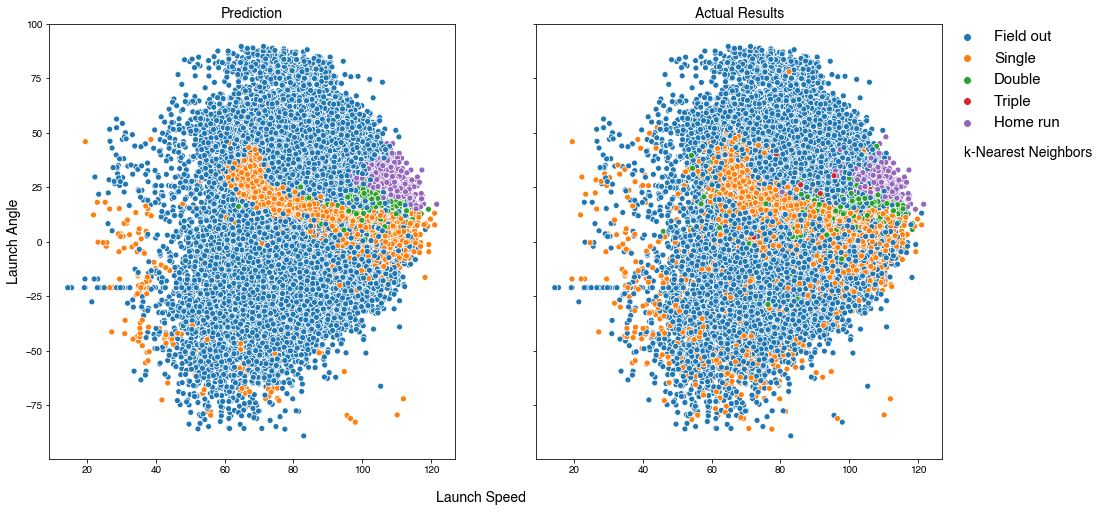

In [9]:
fig, ax_enum = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=True)
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction', 
           data=X_test,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[0])
plt.sca(ax_enum[0])
plt.ylabel("Launch Angle", fontsize=14)
plt.xlabel("", fontsize=14)
ax_enum[0].get_legend().remove()
plt.title("Prediction", fontsize=14)


g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='truth', 
           data=X_test,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[1])
plt.sca(ax_enum[1])
_=plt.title("Actual Results", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
#for ax in ax_enum:
#    ax.tick_params(axis='both', which='major', labelsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)

plt.figtext(s="k-Nearest Neighbors",x=1.03, y=0.65, fontsize=14, ha="right")
_ = plt.figtext(s="Launch Speed",x=0.5, y=0.05, fontsize=14, ha="center")

### Check some other models for comparison

Consider a tree based model (gBDT) and a SVM classifier

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [11]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [12]:
X_test = X_test.loc[:,feature_cols]
print("Score kNN: {0}".format(kneighbors.score(X_test, y_test)))
print("Score SVC: {0}".format(svc.score(X_test, y_test)))
print("Score BDT: {0}".format(gbdt.score(X_test, y_test)))
results_df = X_test.copy()
# BDT
results_df["prediction_val_gbdt"] = gbdt.predict(X_test)
results_df["prediction_gbdt"] = le.inverse_transform(results_df["prediction_val_gbdt"])
# kNN
results_df["prediction_val_kNN"] = kneighbors.predict(X_test)
results_df["prediction_kNN"] = le.inverse_transform(results_df["prediction_val_kNN"])
# SVC
results_df["prediction_val_svc"] = svc.predict(X_test)
results_df["prediction_svc"] = le.inverse_transform(results_df["prediction_val_svc"])


results_df["truth"] = le.inverse_transform(y_test)

full = results_df.join(scrub_data,rsuffix="_redundandt")

Score kNN: 0.7052059925093633
Score SVC: 0.7141385767790263
Score BDT: 0.7406741573033708


In terms of accuracy, BDT > SVC > kNN

To get a better idea of what's going on, plot all 3 next to true outcome

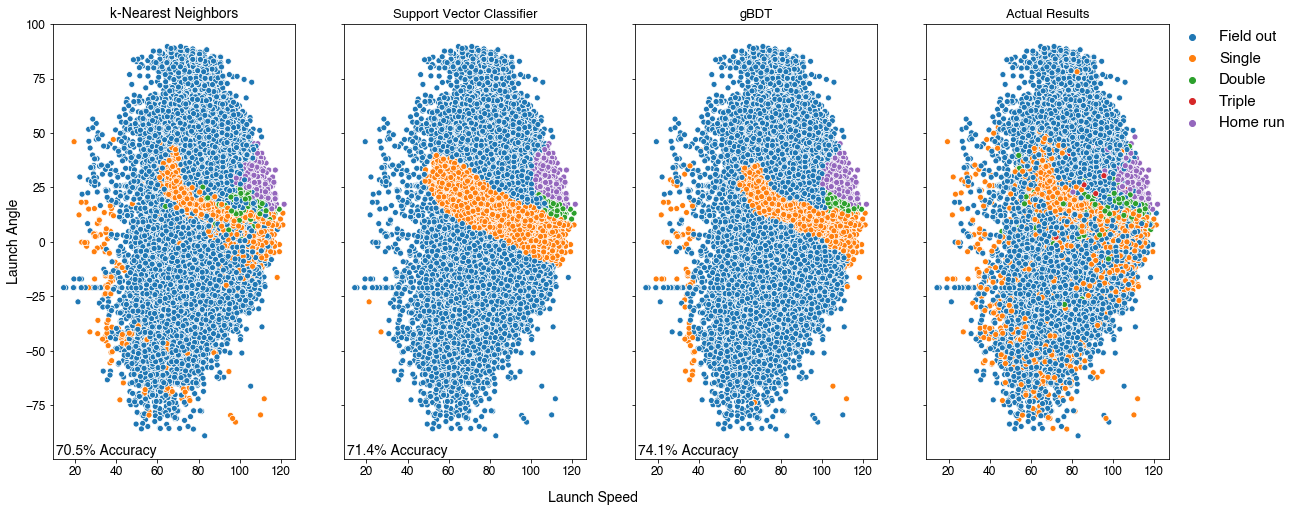

In [13]:
fig, ax_enum = plt.subplots(nrows=1, ncols=4, figsize=(20,8), sharey=True)

# kNN
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_kNN', 
           data=results_df,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[0])
plt.sca(ax_enum[0])
plt.ylabel("Launch Angle", fontsize=14)
plt.xlabel("", fontsize=14)
ax_enum[0].get_legend().remove()
ax_enum[0].annotate("{0}% Accuracy".format(round(100*kneighbors.score(X_test, y_test),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("k-Nearest Neighbors", fontsize=14)

# SVC
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_svc', 
           data=results_df,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[1])
plt.sca(ax_enum[1])
plt.xlabel("", fontsize=14)
ax_enum[1].get_legend().remove()
ax_enum[1].annotate("{0}% Accuracy".format(round(100*svc.score(X_test, y_test),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("Support Vector Classifier", fontsize=13)

# gBDT
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_gbdt', 
           data=results_df,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[2])
plt.sca(ax_enum[2])
plt.xlabel("", fontsize=14)
ax_enum[2].get_legend().remove()
ax_enum[2].annotate("{0}% Accuracy".format(round(100*gbdt.score(X_test, y_test),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("gBDT", fontsize=13)


g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='truth', 
           data=results_df,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[3])
plt.sca(ax_enum[3])
_=plt.title("Actual Results", fontsize=13)
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
for ax in ax_enum:
    ax.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)

_ = plt.figtext(s="Launch Speed",x=0.5, y=0.05, fontsize=14, ha="center")
plt.savefig(saveDir+"/2var_classifier_comp", bbox_inches='tight')

Check explicit rates of predictions to compare against true class populations

In [14]:
print("kNN: ")
print(full["prediction_kNN"].value_counts())
print("\nSVC:")
print(full["prediction_svc"].value_counts())
print("\ngBDT")
print(full["prediction_gbdt"].value_counts())
print("\nTruth")
print(full["truth"].value_counts())

kNN: 
field_out    36338
single       11217
double        3259
home_run      2575
triple          11
Name: prediction_kNN, dtype: int64

SVC:
field_out    31834
single       18292
home_run      2653
double         621
Name: prediction_svc, dtype: int64

gBDT
field_out    36170
single       12721
home_run      2825
double        1684
Name: prediction_gbdt, dtype: int64

Truth
field_out    33149
single       12819
double        4183
home_run      2848
triple         401
Name: truth, dtype: int64


Next look at confusion matrix for how predictions are being misclassified

In [15]:
from sklearn.metrics import confusion_matrix
def conf_matrix(true, pred, classnames):
    conf_mat = confusion_matrix(true, pred,classnames)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    ax.tick_params(axis='both', which='major', labelsize=12)    
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classnames, yticklabels=classnames)

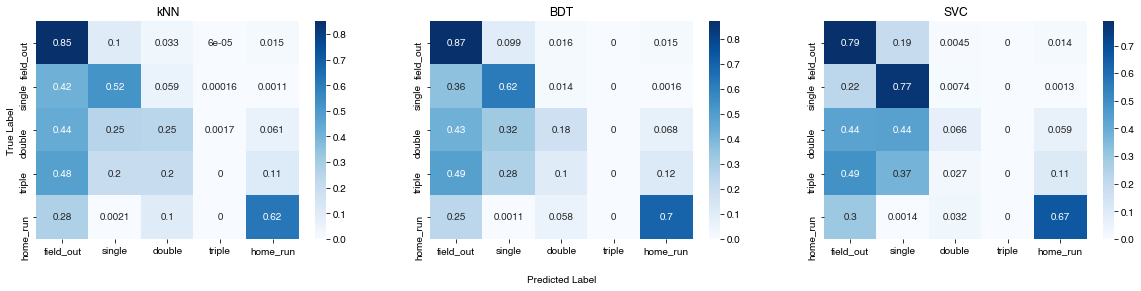

In [16]:
fig, ax_enum = plt.subplots(1,3,figsize=(20,4))
plt.sca(ax_enum[0])
conf_matrix(full["truth"], full["prediction_kNN"], classnames=targets)
plt.title("kNN")
plt.ylabel("True Label")
plt.sca(ax_enum[1])
conf_matrix(full["truth"], full["prediction_gbdt"], classnames=targets)
plt.title("BDT")
plt.xlabel("Predicted Label",labelpad=20)
plt.sca(ax_enum[2])
conf_matrix(full["truth"], full["prediction_svc"], classnames=targets)
plt.title("SVC")
plt.savefig(saveDir+"/2var_confusion",bbox_inches='tight')
plt.show()


So it looks like the BDT does somewhat better on outs and HRs, and notably better on singles. It does worse on doubles but with outs and singles being so much more of the dataset, it gains overall.
This behavior is also notable in the above decision plots, the single boundary is more defined and clear, so there's less things within that really being labeled non-singles. Should rebalance the dataset eventually.

Plan on adding spray angle, but first, let's check the current model against that to see what it's doing

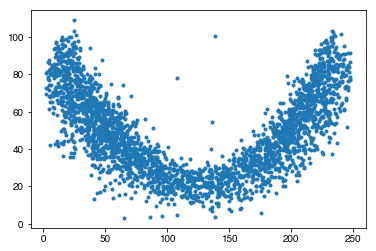

In [17]:
# Verify hc_x, hc_y
h = full[full["events"]=="home_run"]
plt.scatter(h["hc_x"],h["hc_y"], marker='.')

Add spray angle from formula

In [18]:
full["spray_angle"] = np.arctan((full["hc_x"]-125.42)/(198.27-full["hc_y"]))*180/np.pi*.75

/Users/tburch/Documents/gitDevelopment/baseball-studies/venv_py3_baseball/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tburch/Documents/gitDevelopment/baseball-studies/venv_py3_baseball/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


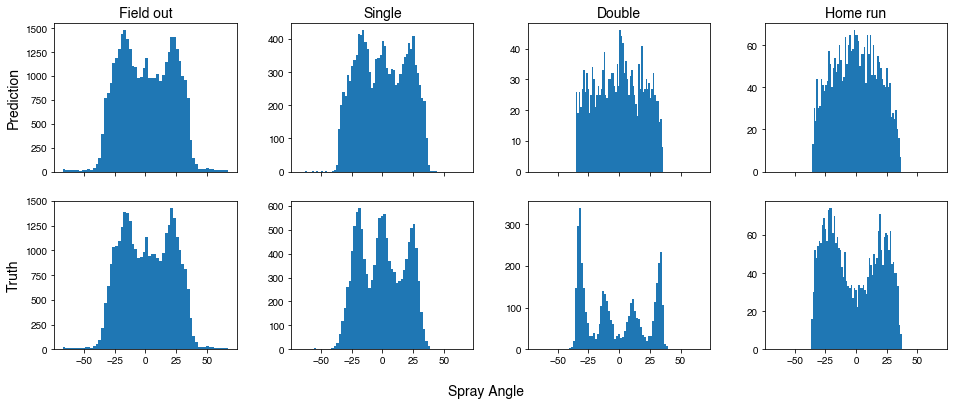

In [19]:
fig, ax_enum = plt.subplots(nrows=2, ncols=4, figsize=(16,6), sharex=True, sharey=False)
plt.subplots_adjust(wspace=.3)
targets_to_plot = ["field_out","single","double","home_run"]
for i,event in enumerate(targets_to_plot):

    p = full[full["prediction_gbdt"] == event]
    plt.sca(ax_enum[0][i])
    plt.hist(p["spray_angle"],bins=60)
    plt.title(event.replace('_',' ').capitalize(),fontsize=14)
    if i ==0:
        plt.ylabel("Prediction",fontsize=14)

    r = full[full["events"] ==event]
    plt.sca(ax_enum[1][i])
    _=plt.hist(r["spray_angle"],bins=60)
    if i ==0:
        plt.ylabel("Truth",fontsize=14)

_=plt.figtext(s=f"Spray Angle", x=0.5, y=0.02, fontsize=14, ha="center")

    
plt.savefig(saveDir+"/spray_angle".format(event),  bbox_inches='tight')
plt.show()

In general look ~okay, however HR prediction is inverted, from reality - that means there's definitely some information we can gain by adding this info.

Adding spray to the model and retrain...

In [20]:
# split 
feature_cols = ['launch_speed', 'launch_angle','spray_angle']
slim_df = full.loc[:, feature_cols+["events"]]
slim_df = slim_df.dropna()
mask = np.random.rand(len(slim_df)) < 0.50
train = slim_df[mask]
test = slim_df[~mask]
# Features
X_train_3feat = train.loc[:, feature_cols]
X_test_3feat = test.loc[:, feature_cols]
y_train_3 = le.transform(train["events"]) 
y_test_3 = le.transform(test["events"])
print(f"Training {X_train_3feat.shape}")
print(f"Testing {X_test_3feat.shape}")

#kneighbors
kneighbors_3 = KNeighborsClassifier(len(le.classes_))
kneighbors_3.fit(X_train_3feat, y_train_3)
#gbdt
gbdt_3 = GradientBoostingClassifier()
gbdt_3.fit(X_train_3feat, y_train_3)
#svc
svc_3 = SVC()
svc_3.fit(X_train_3feat, y_train_3)

Training (26755, 3)
Testing (26532, 3)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
print("Score kNN: {0}".format(kneighbors_3.score(X_test_3feat, y_test_3)))
print("Score SVC: {0}".format(svc_3.score(X_test_3feat, y_test_3)))
print("Score BDT: {0}".format(gbdt_3.score(X_test_3feat, y_test_3)))
results_df_3 = X_test_3feat.copy()
# BDT
results_df_3["prediction_val_gbdt"] = gbdt_3.predict(X_test_3feat)
results_df_3["prediction_gbdt"] = le.inverse_transform(results_df_3["prediction_val_gbdt"])
# kNN
results_df_3["prediction_val_kNN"] = kneighbors_3.predict(X_test_3feat)
results_df_3["prediction_kNN"] = le.inverse_transform(results_df_3["prediction_val_kNN"])
# SVC
results_df_3["prediction_val_svc"] = svc_3.predict(X_test_3feat)
results_df_3["prediction_svc"] = le.inverse_transform(results_df_3["prediction_val_svc"])

results_df_3["truth"] = le.inverse_transform(y_test_3)

full = results_df_3.join(scrub_data,rsuffix="_redundandt")

Score kNN: 0.7608171264887683
Score SVC: 0.6891677973767526
Score BDT: 0.7765339966832504


This hurt the SVM quite a bit, moved the decision boundary pretty far

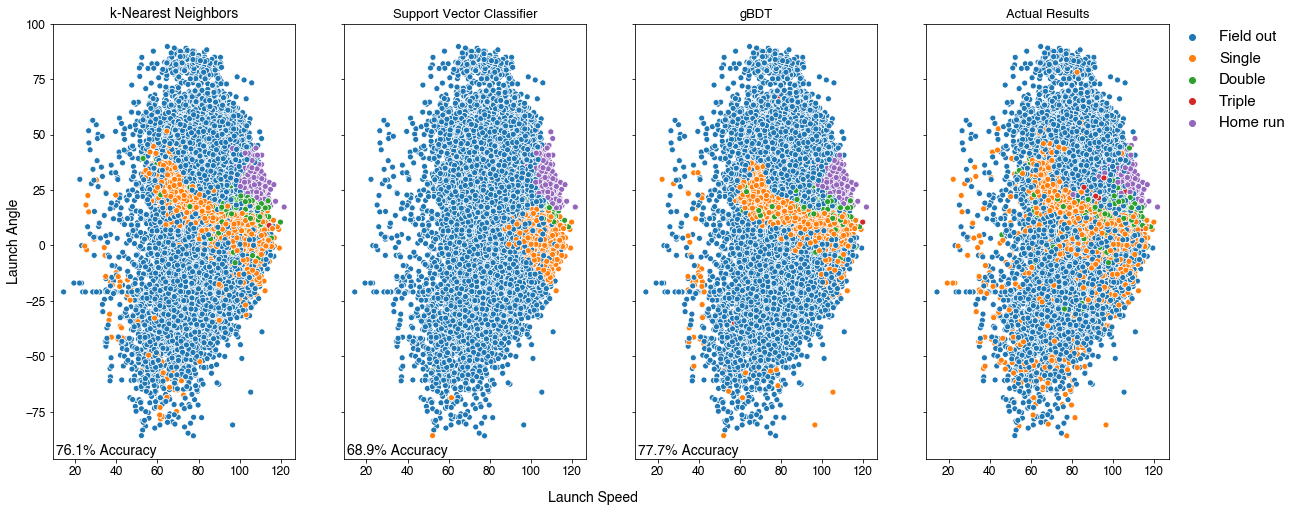

In [22]:
fig, ax_enum = plt.subplots(nrows=1, ncols=4, figsize=(20,8), sharey=True)

plt.title("3 Variable Model")

# kNN
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_kNN', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[0])
plt.sca(ax_enum[0])
plt.ylabel("Launch Angle", fontsize=14)
plt.xlabel("", fontsize=14)
ax_enum[0].get_legend().remove()
ax_enum[0].annotate("{0}% Accuracy".format(round(100*kneighbors_3.score(X_test_3feat, y_test_3),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("k-Nearest Neighbors", fontsize=14)

# SVC
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_svc', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[1])
plt.sca(ax_enum[1])
plt.xlabel("", fontsize=14)
ax_enum[1].get_legend().remove()
ax_enum[1].annotate("{0}% Accuracy".format(round(100*svc_3.score(X_test_3feat, y_test_3),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("Support Vector Classifier", fontsize=13)

# gBDT
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_gbdt', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[2])
plt.sca(ax_enum[2])
plt.xlabel("", fontsize=14)
ax_enum[2].get_legend().remove()
ax_enum[2].annotate("{0}% Accuracy".format(round(100*gbdt_3.score(X_test_3feat, y_test_3),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("gBDT", fontsize=13)


g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='truth', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[3])
plt.sca(ax_enum[3])
_=plt.title("Actual Results", fontsize=13)
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
for ax in ax_enum:
    ax.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)

_ = plt.figtext(s="Launch Speed",x=0.5, y=0.05, fontsize=14, ha="center")
plt.savefig(saveDir+"/3var_classifier_comp", bbox_inches='tight')

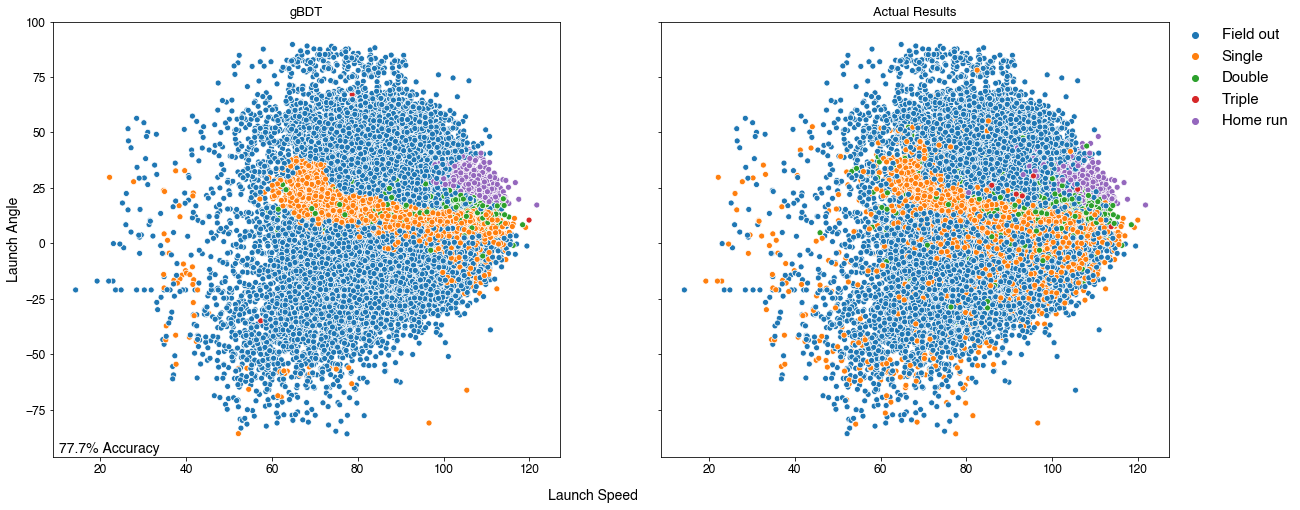

In [23]:
fig, ax_enum = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharey=True)
# gBDT
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction_gbdt', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[0])
plt.sca(ax_enum[0])
plt.xlabel("", fontsize=14)
plt.ylabel("Launch Angle", fontsize=14)
ax_enum[0].get_legend().remove()
ax_enum[0].annotate("{0}% Accuracy".format(round(100*gbdt_3.score(X_test_3feat, y_test_3),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
plt.title("gBDT", fontsize=13)

g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='truth', 
           data=results_df_3,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[1])
plt.sca(ax_enum[1])
_=plt.title("Actual Results", fontsize=13)
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
for ax in ax_enum:
    ax.tick_params(axis='both', which='major', labelsize=12)
    
handles, labels = ax.get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)

_ = plt.figtext(s="Launch Speed",x=0.5, y=0.05, fontsize=14, ha="center")
plt.savefig(saveDir+"/unoptimized_gbdt", bbox_inches='tight')

In [24]:
print("kNN: ")
print(full["prediction_kNN"].value_counts())
print("\nSVC:")
print(full["prediction_svc"].value_counts())
print("\ngBDT")
print(full["prediction_gbdt"].value_counts())
print("\nTruth")
print(full["truth"].value_counts())

kNN: 
field_out    17533
single        5733
double        2027
home_run      1230
triple           9
Name: prediction_kNN, dtype: int64

SVC:
field_out    21325
single        3661
home_run       986
double         560
Name: prediction_svc, dtype: int64

gBDT
field_out    17968
single        5870
double        1390
home_run      1285
triple          19
Name: prediction_gbdt, dtype: int64

Truth
field_out    16474
single        6365
double        2108
home_run      1381
triple         204
Name: truth, dtype: int64


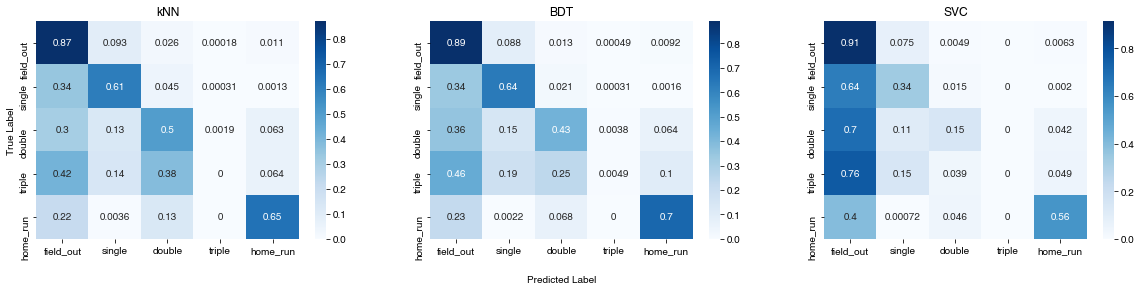

In [25]:
fig, ax_enum = plt.subplots(1,3,figsize=(20,4))
plt.sca(ax_enum[0])
conf_matrix(full["truth"], full["prediction_kNN"], classnames=targets)
plt.title("kNN")
plt.ylabel("True Label")
plt.sca(ax_enum[1])
conf_matrix(full["truth"], full["prediction_gbdt"], classnames=targets)
plt.title("BDT")
plt.xlabel("Predicted Label",labelpad=20)
plt.sca(ax_enum[2])
conf_matrix(full["truth"], full["prediction_svc"], classnames=targets)
plt.title("SVC")
plt.savefig(saveDir+"/3var_confusion",bbox_inches='tight')
plt.show()

So adding spray angle helps kNN and the BDT by a few percent, but makes the SVC not work so well. It also just seems to be _way_ overpredicting outs at the moment.